# IBM Price Prediction
Predicts IBM Prices from [Yahoo Finance](https://query1.finance.yahoo.com/v7/finance/download/IBM?period1=-252374400&period2=1590624000&interval=1d&events=history)

## Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
plt.rcParams['figure.figsize'] = (18, 10)
print(tf.__version__)

2.2.0


## Constants

In [3]:
DATA_URL = "https://query1.finance.yahoo.com/v7/finance/download/IBM?period1=-252374400&period2=1590624000&interval=1d&events=history"
TRAIN_DATE_BOUNDARY = '2020-01-01'
EPOCHS = 60
BATCH_SIZE = 31
STEPS = 7

## Download data
Download data from Yahoo finance and partition to test and training

In [4]:
data = pd.read_csv(DATA_URL)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,7.713333,7.713333,7.626667,7.626667,0.609973,387200
1,1962-01-03,7.626667,7.693333,7.626667,7.693333,0.615304,288000
2,1962-01-04,7.693333,7.693333,7.613333,7.616667,0.609173,256000
3,1962-01-05,7.606667,7.606667,7.453333,7.466667,0.597176,363200
4,1962-01-08,7.460000,7.460000,7.266667,7.326667,0.585979,544000


Visualize

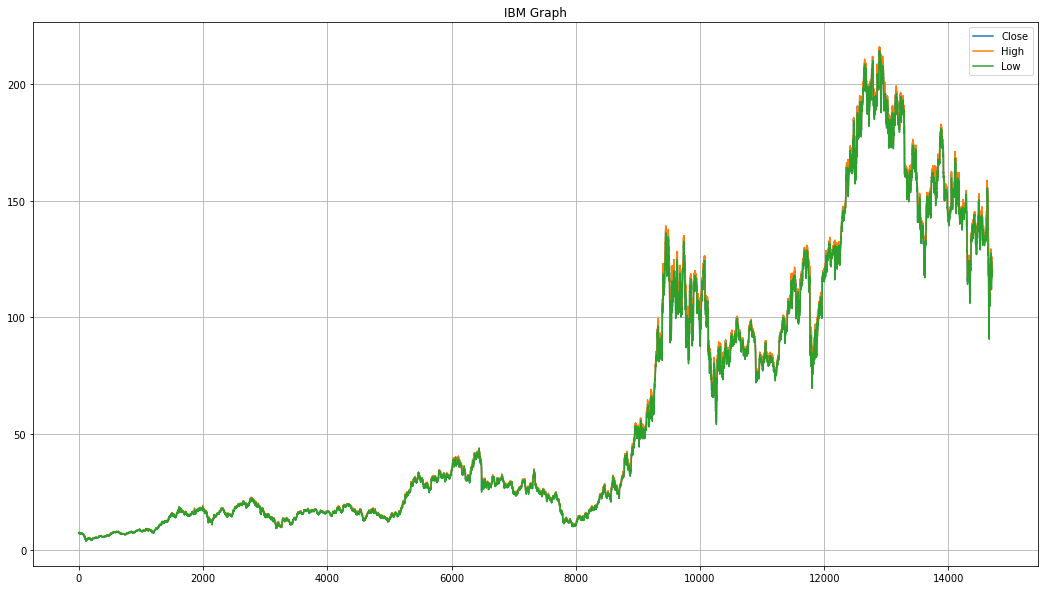

In [5]:
data.plot(title="IBM Graph", grid=True, y=['Close', 'High', 'Low'])

## Split Data (Training &  Testing)

In [6]:
training_data = data[data['Date'] < TRAIN_DATE_BOUNDARY]
training_data.drop(inplace=True, columns=['Date', 'Adj Close'], axis=1)
training_data.head()

/media/cornelius/Data/Workspace/Python Projects/Tensorflow Journey/lstm-stock-prediction/.venv/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,Open,High,Low,Close,Volume
0,7.713333,7.713333,7.626667,7.626667,387200
1,7.626667,7.693333,7.626667,7.693333,288000
2,7.693333,7.693333,7.613333,7.616667,256000
3,7.606667,7.606667,7.453333,7.466667,363200
4,7.460000,7.460000,7.266667,7.326667,544000


In [7]:
test_data = data[data['Date'] >= TRAIN_DATE_BOUNDARY]
test_data = test_data.drop(columns=['Date', 'Adj Close'], axis=1)

Function for separating features and labels. Also converts data into timesteps

In [8]:
def data_timesteps(features, labels, steps = 1):
    x_data = []
    y_data = []
    for i in range(steps, features.shape[0]):
        x_data.append(features[(i - steps): i])
        y_data.append(labels[i])
    return np.array(x_data), np.array(y_data)

In [9]:
training_features = training_data[['Open', 'High', 'Low']]
training_labels = training_data[['Close']]

In [10]:
labels_scaler = MinMaxScaler()
features_scaler = MinMaxScaler()

In [11]:
training_features = features_scaler.fit_transform(training_features)
training_labels = labels_scaler.fit_transform(training_labels)

In [12]:
training_features.shape

(14600, 3)

In [13]:
training_features, training_labels = data_timesteps(training_features, training_labels, STEPS)
training_features.shape, training_labels.shape

((14593, 7, 3), (14593, 1))

## Define & Train Model

In [14]:
# model = keras.Sequential()
# model.add(
#   keras.layers.Bidirectional(
#     keras.layers.LSTM(
#       units=128, 
#       input_shape=(training_features.shape[1], training_features.shape[2]),
#       activation='relu'
#     )
#   )
# )
# model.add(keras.layers.Dropout(rate=0.2))
# model.add(keras.layers.Dense(units=1))
# model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=40, input_shape=(training_features.shape[1], training_features.shape[2]),
      activation='relu',
      return_sequences=True
    )
)
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(units=60, activation='relu', return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(units=80, activation='relu', return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.LSTM(units=120, activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
model_results = model.fit(
    training_features, 
    training_labels, 
    epochs=EPOCHS, 
    batch_size=BATCH_SIZE, 
    validation_split=0.1, 
    shuffle=False
)

Epoch 1/60
424/424 [==============================] - 8s 19ms/step - loss: 0.0036 - val_loss: 0.0195
Epoch 2/60
424/424 [==============================] - 8s 18ms/step - loss: 0.0189 - val_loss: 0.0174
Epoch 3/60
424/424 [==============================] - 7s 17ms/step - loss: 0.0193 - val_loss: 0.0151
Epoch 4/60
424/424 [==============================] - 7s 17ms/step - loss: 0.0212 - val_loss: 0.0143
Epoch 5/60
424/424 [==============================] - 7s 18ms/step - loss: 0.0247 - val_loss: 0.0293
Epoch 6/60
424/424 [==============================] - 8s 18ms/step - loss: 0.0226 - val_loss: 0.0024
Epoch 7/60
424/424 [==============================] - 8s 18ms/step - loss: 0.0095 - val_loss: 0.0040
Epoch 8/60
424/424 [==============================] - 7s 18ms/step - loss: 0.0034 - val_loss: 0.0030
Epoch 9/60
424/424 [==============================] - 8s 19ms/step - loss: 0.0021 - val_loss: 0.0024
Epoch 10/60
424/424 [==============================] - 8s 19ms/step - loss: 0.0016 - val_lo

### Model Validation

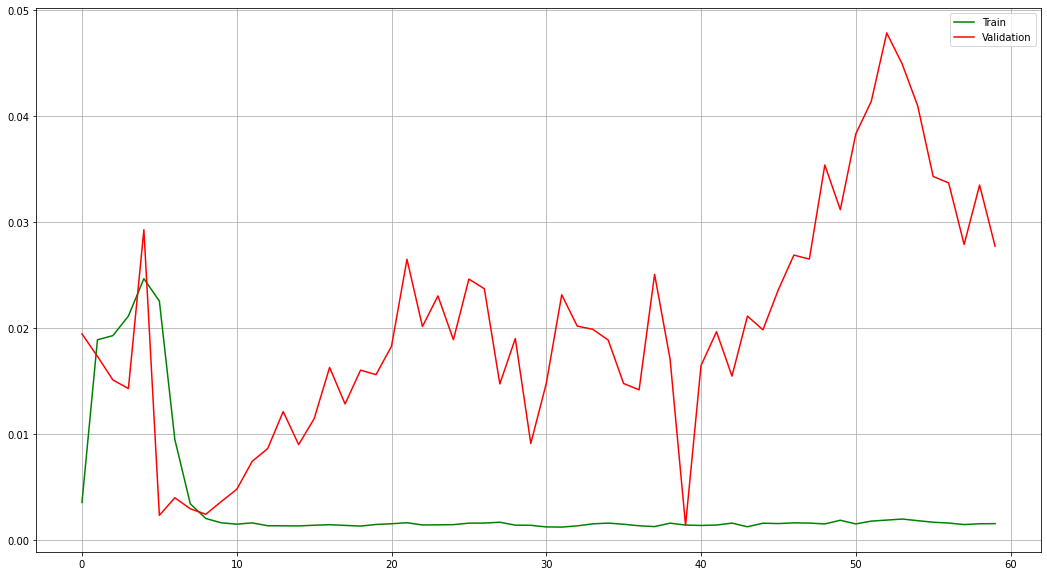

In [17]:
plt.plot(model_results.history['loss'], label='Train', color='green')
plt.plot(model_results.history['val_loss'], label='Validation', color='red')
plt.legend()
plt.grid(True)
plt.show()

### Test Model

Test features time step function

In [18]:
test_features = test_data[['Open', 'High', 'Low']]
test_labels = test_data[['Close']]

Transform test features

In [19]:
test_features = features_scaler.fit_transform(test_features)
# test_labels = labels_scaler.fit_transform(test_labels)

In [20]:
test_features, test_labels = data_timesteps(test_features, test_labels.to_numpy(), STEPS)
test_features.shape, test_labels.shape

((94, 7, 3), (94, 1))

Model predict test data

In [21]:
label_prediction = model.predict(test_features)
label_prediction.shape

(94, 1)

Scale prediction back original values

In [22]:
label_prediction = labels_scaler.inverse_transform(label_prediction)

### Plot Prediction

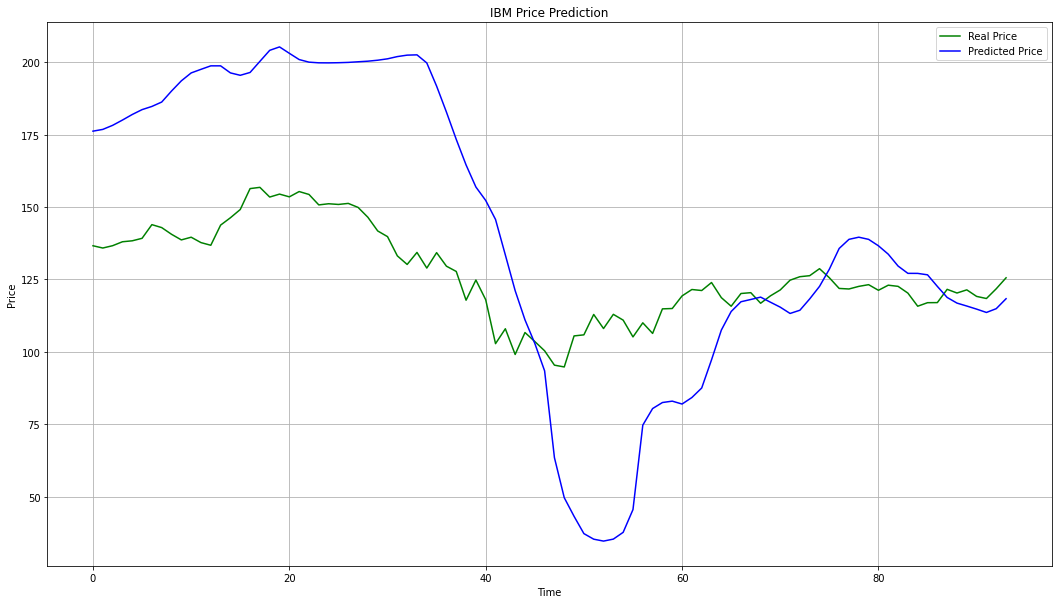

In [23]:
plt.plot(test_labels, color="green", label="Real Price")
plt.plot(label_prediction, color="blue", label="Predicted Price")
plt.title("IBM Price Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

### Save Model

In [24]:
model.save("ibm-prediction-model.h5")